# Poisson regression

In [1]:
using CSV
using DataFrames
using Optim
using Random
using StatsBase
using Distributions
import CairoMakie as MK

##  Read data

In [2]:
covid = CSV.read("../data/simulated/01-lima-over-dispersion.csv", DataFrame)

Row,districts,population,predictor,cases
,String31,Int64,Float64,Int64
1,San Juan de Lurigancho,1091303,-0.175,136119
2,San Martín de Porres,700178,1.159,120072
3,Ate,630085,-1.042,69214
4,Comas,524894,-0.156,62119
5,Villa El Salvador,463014,1.72,71370
6,Villa María del Triunfo,448545,-1.386,49273
7,San Juan de Miraflores,404001,0.536,64302
8,Los Olivos,371229,-0.786,51088
9,Puente Piedra,353327,0.133,55446


## Point estimate

Only computes the term of loglikelihood that are not constant.

In [3]:
function loglikepoisson(β, data)
    # data
    y = data.cases
    x = data.predictor
    N = data.population

    # loglike function
    η = β[1] .+ x * β[2]
    out = - sum(N .* exp.(η))
    out += sum(y .* η)
end

loglikepoisson (generic function with 1 method)

Minimize the negative loglikelihood.

In [4]:
β0 = [0.0, 0.0]
negloglikepoisson(β) = -loglikepoisson(β, covid)
optim = optimize(negloglikepoisson, β0, Newton(); autodiff = :forward)
β_ml = Optim.minimizer(optim)

2-element Vector{Float64}:
 -2.0011638693781895
  0.12148936630419212

In [5]:
exp.(β_ml)

2-element Vector{Float64}:
 0.1351778622711557
 1.1291773585327725

Compare observed with predicted mean

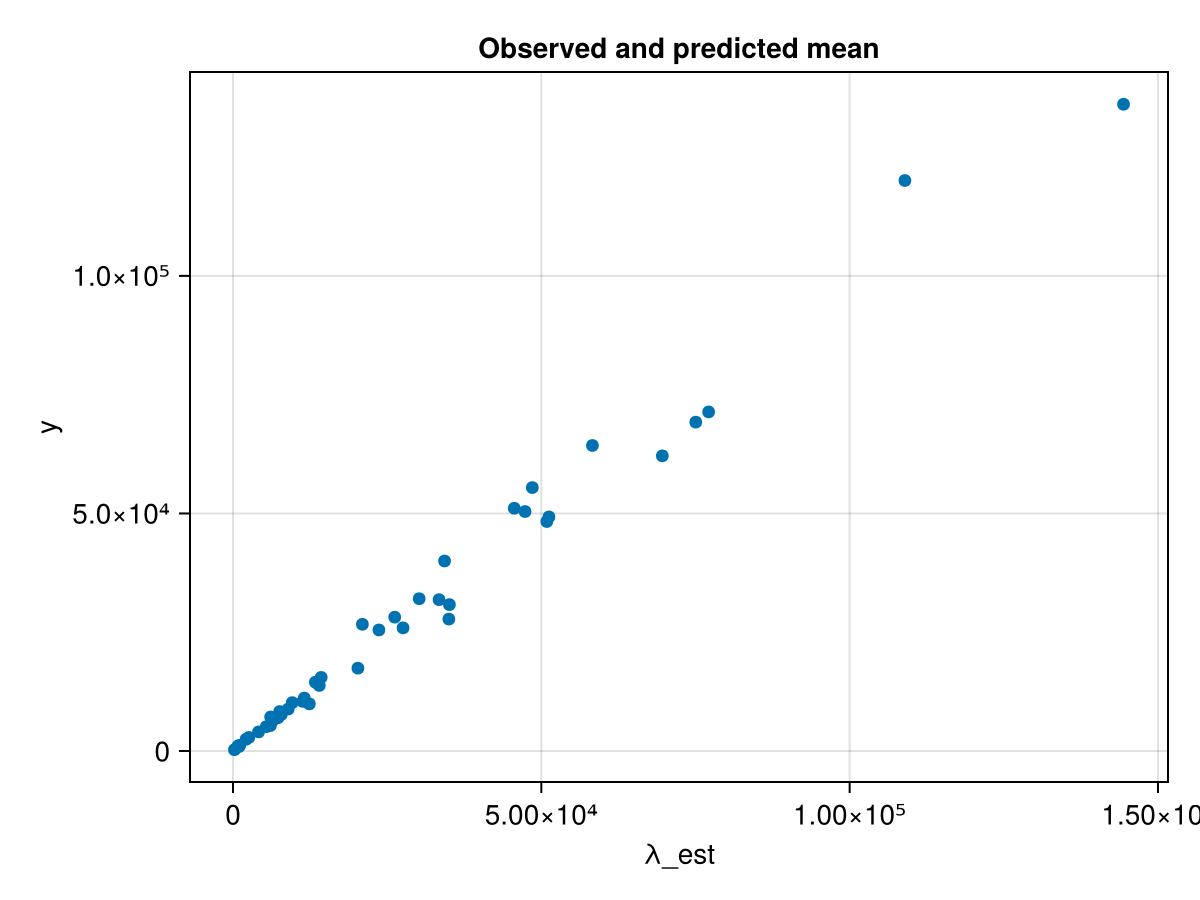

In [6]:
predictpoisreg(β, df) = exp.(β[1] .+ df.predictor * β[2]) .* df.population
λ_est = predictpoisreg(β_ml, covid)
axis_args = (title = "Observed and predicted mean", xlabel = "λ_est", ylabel = "y")
MK.scatter(λ_est, covid.cases, axis = axis_args)

## Bootstrap to obtain confidence interval

Function to obtain regression coefficients.

In [7]:
function poiscoef(data)
    β0 = [0.0, 0.0]
    negloglikepoisson(β) = -loglikepoisson(β, data)
    optim = optimize(negloglikepoisson, β0, Newton(); autodiff = :forward)
    Optim.minimizer(optim)
end

poiscoef (generic function with 1 method)

Bootstrap.

In [8]:
n = size(covid, 1)
m = 5000
bootstraps = zeros(m, 2)
for i = 1:m
    ind_res = sample(1:n, n)
    data_boot = covid[ind_res, :]
    bootstraps[i, :] = poiscoef(data_boot)
end

visualize bootstrap

In [9]:
axis_args = (xlabel = "β₀", ylabel = "β₁", title = "Bootstrap samples")
MK.scatter(bootstraps[:,1], bootstraps[:, 2], axis = axis_args, markersize = 6)
MK.scatter!([β_ml[1]], [β_ml[2]], label = "β_est", color = :red)

Makie.Scatter{Tuple{Vector{GeometryBasics.Point{2, Float64}}}}

confidente interval

In [10]:
α = 0.05
quantile(bootstraps[:, 1], [α/2, 1-α/2])
quantile(bootstraps[:, 2], [α/2, 1-α/2])

2-element Vector{Float64}:
 0.0729816798602368
 0.1649246266918841

## Overdispersion test

Define statistic

In [11]:
over_stat(y, λ) = sum((λ - y) .^ 2 ./ λ)

over_stat (generic function with 1 method)

Computes observed statistic

In [12]:
stat_obs = over_stat(covid.cases, λ_est)

12785.896329483585

Monte carlo sampling to obtain statistic under H₀

In [13]:
m = 1000
mc_stat = zeros(m)
for i = 1:m
    y_mc = rand.(Poisson.(λ_est))
    mc_stat[i] = over_stat(y_mc, λ_est)
end

Distribution and p-value

In [14]:
MK.hist(mc_stat, normalization = :pdf, strokewidth = 1)
pvalue = sum(mc_stat .> stat_obs)

0

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*